In [33]:
#importing neccessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Data Preprocessing:

In [34]:
# Use a different encoding, e.g., 'latin-1' or 'ISO-8859-1'
df_project = pd.read_csv(r"C:\Users\ankur\Downloads\archive (1)\data.csv", encoding='latin-1')

In [35]:
#check for the size of the dataset in terms of rows and columns
df_project.shape

(541909, 8)

In [36]:
#displaying the column names
df_project.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [37]:
#description of the dataset
df_project.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [38]:
#checking for null values in the dataset using any() method
df_project.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [39]:
# Filling the NA values with Unkown Description
df_project["Description"].fillna("Unknown Description", inplace = True)

In [40]:
# Filling the NA values with 0 for CustomerID column
df_project["CustomerID"].fillna(0, inplace = True)

In [41]:
#checking for null values in the dataset using any() method
df_project.isnull().any()

InvoiceNo      False
StockCode      False
Description    False
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID     False
Country        False
dtype: bool

In [42]:
# Converting the customerID column from float64 to int64 datatype
df_project['CustomerID'] = df_project['CustomerID'].astype('int')

In [43]:
from datetime import datetime
df_project['InvoiceDate']=pd.to_datetime(df_project['InvoiceDate'])

In [44]:
# Checking for data types
df_project.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int32
Country                object
dtype: object

In [45]:
# Checking for duplicated values
total_duplicates = df_project.duplicated().sum()

print("Total number of duplicate rows:", total_duplicates)

#we can ignore the duplicate data in this dataset as multiple customer might buy same item.

Total number of duplicate rows: 5268


# RFM Calculation:

In [46]:
# Calculate Recency, Frequency, and Monetary values for each customer
today = datetime.now()

In [47]:
# Calculate Recency
df_project['Recency'] = today - df_project['InvoiceDate']
recency_df = df_project.groupby('CustomerID')['Recency'].min().reset_index()
recency_df['Recency'] = recency_df['Recency'].dt.days

In [48]:
# Calculate Frequency

frequency_df = df_project.groupby('CustomerID')['InvoiceDate'].count().reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']


In [49]:
monetary_df = df_project.groupby('CustomerID')['UnitPrice'].sum().reset_index()
monetary_df.columns = ['CustomerID', 'Monetary']


In [50]:
rfm_df = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')

In [51]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
rfm_df[['Recency', 'Frequency','Monetary']] = scaler.fit_transform(rfm_df[['Recency', 'Frequency','Monetary']])
rfm_standardized_df = rfm_df[['Recency', 'Frequency','Monetary']]

# Customer Segmentation:

C:\Users\ankur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ankur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ankur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ankur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\clus

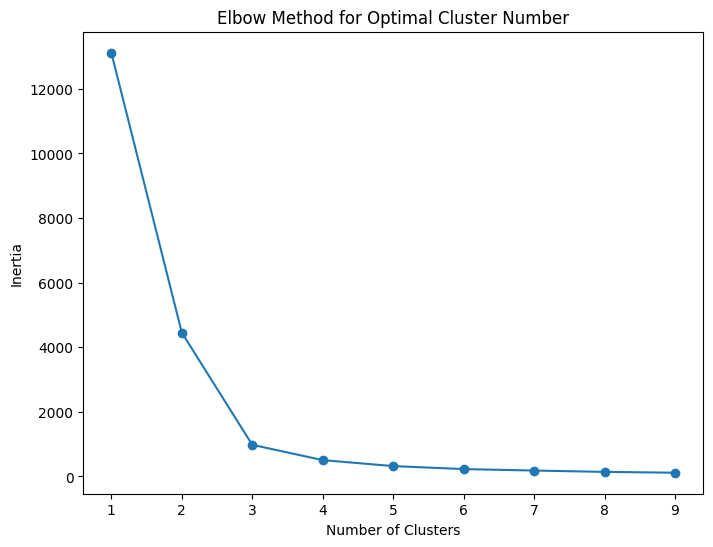

In [52]:
from sklearn.cluster import KMeans
# Determine the optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 10):
 kmeans = KMeans(n_clusters=k, random_state=0)
 kmeans.fit(rfm_standardized_df)
 inertia.append(kmeans.inertia_)
# Plot the Elbow Method to find the optimal number of clusters
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Cluster Number')
plt.show()

In [53]:
# Choose the optimal number of clusters
optimal_clusters = 3 # Choose based on the Elbow Method result
# Apply K-means clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_standardized_df)

C:\Users\ankur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# RFM Segmentation:

In [54]:
# Analyze the characteristics of each customer segment
segment_analysis = rfm_df.groupby('Cluster').agg({
 'Recency': 'mean',
 'Frequency': 'mean',
 'Monetary': 'mean',
 'CustomerID': 'count'
}).reset_index()

# Assign RFM scores based on quartiles
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], q=[0, 0.25, 0.5, 0.75, 1], labels=[4, 3, 2, 1])
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'], q=[0, 0.25, 0.5, 0.75, 1], labels=[1, 2, 3, 4])
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], q=[0, 0.25, 0.5, 0.75, 1], labels=[1, 2, 3, 4])

#Score 1. High-Value Customers: Low recency, high frequency, and high monetary scores.
#Score 2. Potential Loyal Customers: Recent purchases, high frequency, moderate monetary scores. 
#Score 3. New Customers: Very recent purchases, low frequency, and low monetary scores
#Score 4. Churned Customers: High recency, low frequency, and low monetary scores.

In [55]:
rfm_df

,CustomerID,Recency,Frequency,Monetary,Cluster,R_Score,F_Score,M_Score
0,0,-0.908709,65.696532,65.921437,1,4,4,4
1,12346,2.316822,-0.059351,-0.034420,2,1,1,1
2,12347,-0.888860,0.028273,-0.005453,0,4,4,4
3,12348,-0.164356,-0.045234,-0.023741,0,2,2,3
4,12349,-0.730064,-0.024789,0.002036,0,3,3,4
...,...,...,...,...,...,...,...,...
4368,18280,1.840436,-0.055457,-0.031665,2,1,1,1
4369,18281,0.877739,-0.056917,-0.032166,2,1,1,1
4370,18282,-0.839236,-0.053997,-0.030756,0,4,1,2
4371,18283,-0.878935,0.307695,0.039267,0,4,4,4


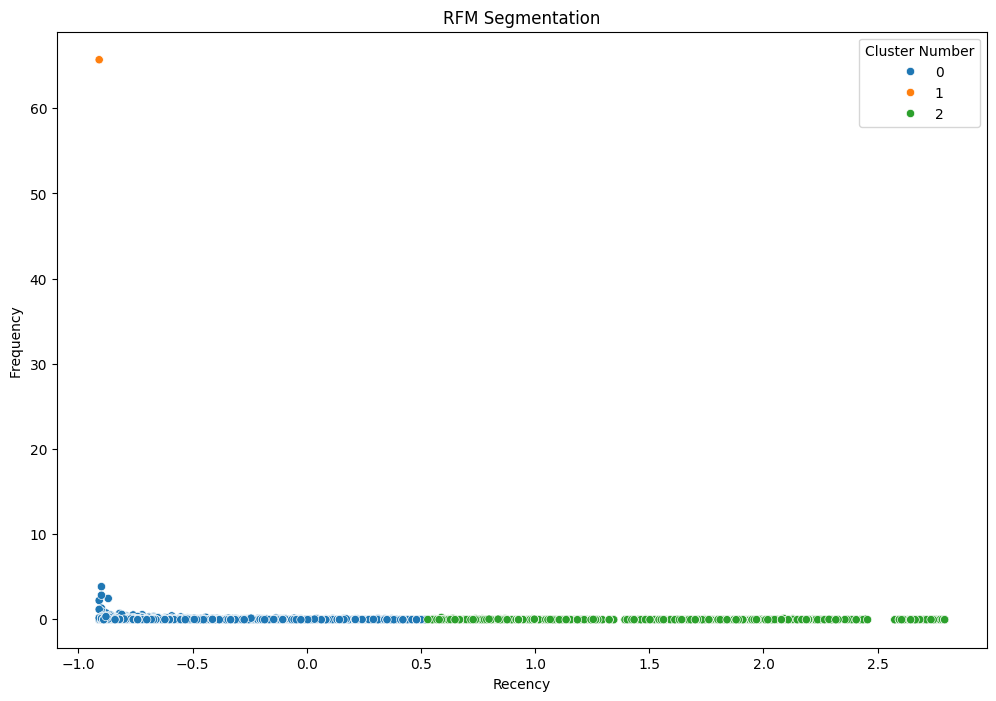

In [56]:
# Visualize the distribution of customers in each segment and their RFM scores
plt.figure(figsize=(12, 8))
sca=sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=rfm_df, palette='tab10')
plt.title('RFM Segmentation')
plt.xlabel('Recency')
plt.ylabel('Frequency ')
sca.get_legend().set_title("Cluster Number")
plt.show()

# Segment Profiling:


In [57]:
print(segment_analysis)

print("""\nWe have two profiles of customer in our dataset.
      Cluster 0 represents  New customers
      Cluster 3 represents  Churned customers""")

   Cluster   Recency  Frequency   Monetary  CustomerID
0        0 -0.509690  -0.004877  -0.011544        3294
1        1 -0.908709  65.696532  65.921437           1
2        2  1.558281  -0.046042  -0.025876        1078

We have two profiles of customer in our dataset.
      Cluster 0 represents  New customers
      Cluster 3 represents  Churned customers


# Visualization

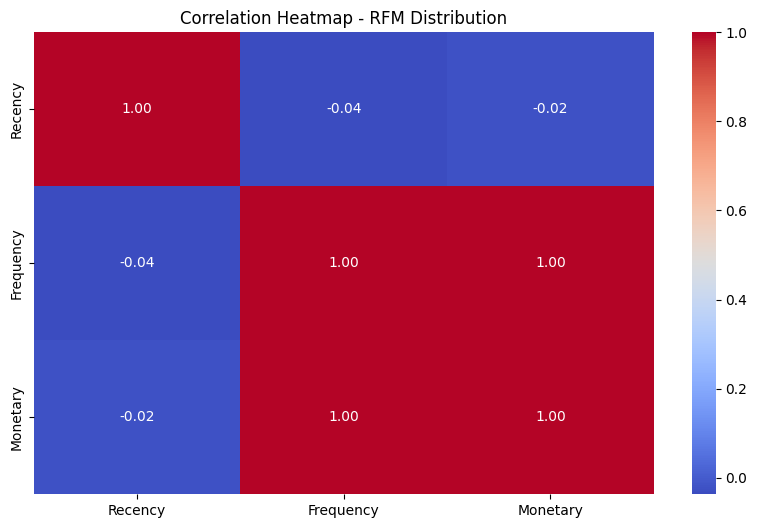

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt


# RFM Distribution Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(rfm_df[['Recency', 'Frequency', 'Monetary']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap - RFM Distribution')
plt.show()


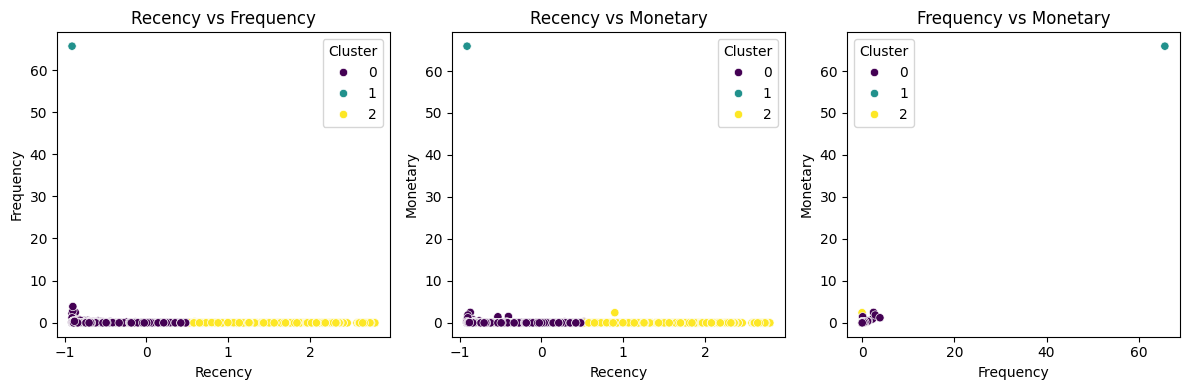

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for RFM distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.scatterplot(data=rfm_df, x='Recency', y='Frequency', hue='Cluster', palette='viridis')
plt.title('Recency vs Frequency')

plt.subplot(1, 3, 2)
sns.scatterplot(data=rfm_df, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Recency vs Monetary')

plt.subplot(1, 3, 3)
sns.scatterplot(data=rfm_df, x='Frequency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Frequency vs Monetary')

plt.tight_layout()
plt.show()

# Marketing Recommendations:

o Provide actionable marketing recommendations for each customer segment. How
can the business tailor its marketing strategies for each group to improve customer
retention and maximize revenue?

1. Decrease Processing Time:
Streamlining and optimizing order processing is imperative. Implementing efficient logistics and order fulfillment systems can significantly reduce processing time, ensuring prompt delivery and enhancing overall customer satisfaction
.22.
Reduce Return and Refund Orders:
A meticulous analysis of product descriptions, images, and customer reviews can help mitigate the likelihood of returns. By enhancing the accuracy of product information, you can minimize customer dissatisfaction and subsequent return/refund requ. s3. .

Arrange Items for Customer Convenience:
Organizing your product catalog in a user-friendly manner enhances the overall shopping experience. Employ intuitive categorization and search features, enabling customers to find items effortlessly. Tailoring recommendations based on past purchases further adds a person. o4. uch.

Improve Customer Service for Enhanced Recency and Frequency Scores:
Elevating customer service directly impacts Recency and Frequency scores. Swift and effective resolution of customer queries, personalized communication, and proactive issue resolution contribute to a positive customer experience. Implementing customer feedback mechanisms aids continuous improvement.

By addressing these aspects, you not only optimize operational efficiency but also cultivate a customer-centric approach, fostering loyalty and boosting the likelihood of repeat business.

# Tasks

## 1. Data Overview

1. What is the size of the dataset in terms of the number of rows and columns?

2. Can you provide a brief description of each column in the dataset?

3. What is the time period covered by this dataset?


In [60]:
#1
df_project.shape

(541909, 9)

In [61]:
#2
df_project.describe

<bound method NDFrame.describe of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  Cu

In [62]:
#3
# Find the minimum and maximum dates in the dataset
min_date = df_project['InvoiceDate'].min()
max_date = df_project['InvoiceDate'].max()

print(f"Time Period Covered: From {min_date} to {max_date}")

Time Period Covered: From 2010-12-01 08:26:00 to 2011-12-09 12:50:00


## 2. Customer Analysis
   
* How many unique customers are there in the dataset?
  
* What is the distribution of the number of orders per customer?
  
* Can you identify the top 5 customers who have made the most purchases by order
count?

In [63]:
#1
df_project = df_project[df_project['CustomerID'] != 0]

num_unique_customers = df_project['CustomerID'].nunique()
print(f"Number of Unique Customers: {num_unique_customers}")

Number of Unique Customers: 4372


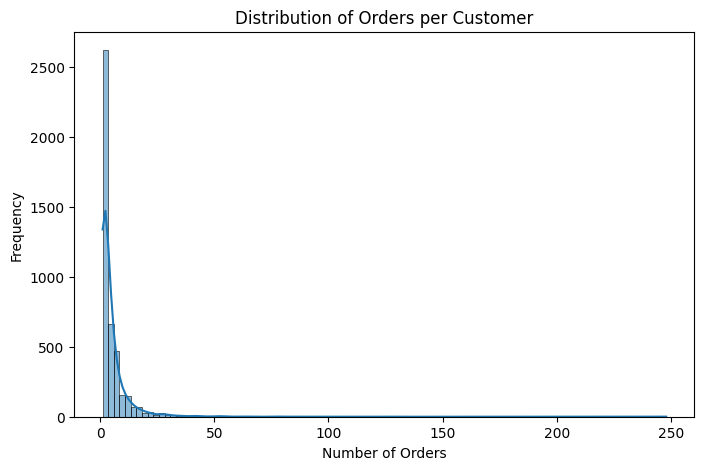

In [64]:
#2
orders_per_customer = df_project.groupby('CustomerID')['InvoiceNo'].nunique()
plt.figure(figsize=(8,5))
sns.histplot(orders_per_customer, bins=100, kde=True)
plt.title('Distribution of Orders per Customer')
plt.xlabel('Number of Orders')
plt.ylabel('Frequency')
plt.show()

In [65]:
#3
top_customers_by_orders = df_project.groupby('CustomerID')['InvoiceNo'].nunique().sort_values(ascending=False).head(5)
print("\nTop 5 Customers with Most Purchases by Order Count:\n")
print(top_customers_by_orders)


Top 5 Customers with Most Purchases by Order Count:

CustomerID
14911    248
12748    224
17841    169
14606    128
13089    118
Name: InvoiceNo, dtype: int64


## 3. Product Analysis

1. What are the top 10 most frequently purchased products?
   
2. What is the average price of products in the dataset?
   
3. Can you find out which product category generates the highest revenue?

In [66]:
#1
top_10_products = df_project['Description'].value_counts().head(10)
print("Top 10 Most Frequently Purchased Products:")
print(top_10_products)

Top 10 Most Frequently Purchased Products:
Description
WHITE HANGING HEART T-LIGHT HOLDER    2070
REGENCY CAKESTAND 3 TIER              1905
JUMBO BAG RED RETROSPOT               1662
ASSORTED COLOUR BIRD ORNAMENT         1418
PARTY BUNTING                         1416
LUNCH BAG RED RETROSPOT               1358
SET OF 3 CAKE TINS PANTRY DESIGN      1232
POSTAGE                               1196
LUNCH BAG  BLACK SKULL.               1126
PACK OF 72 RETROSPOT CAKE CASES       1080
Name: count, dtype: int64


In [67]:
#2
average_price = df_project['UnitPrice'].mean()
print(f"Average Price of Products: $", round(average_price,2))

Average Price of Products: $ 3.46


In [68]:
#3
df_project['Revenue'] = df_project['Quantity'] * df_project['UnitPrice']
prod_revenue = df_project.groupby('Description')['Revenue'].sum()

highest_revenue_product = prod_revenue.idxmax()
highest_revenue_price = prod_revenue.max()

print(f"Product Category Generating the Highest Revenue: ",highest_revenue_product )
print(f"Total Revenue of the Product Category:",highest_revenue_price )

Product Category Generating the Highest Revenue:  REGENCY CAKESTAND 3 TIER
Total Revenue of the Product Category: 132870.4


C:\Users\ankur\AppData\Local\Temp\ipykernel_27156\3661982701.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_project['Revenue'] = df_project['Quantity'] * df_project['UnitPrice']


## 4. Time Analysis

1. Is there a specific day of the week or time of day when most orders are placed?
   
2. What is the average order processing time?
   
3. Are there any seasonal trends in the dataset?

In [69]:
#1
df_project['InvoiceDate'] = pd.to_datetime(df_project['InvoiceDate'])

# Day of the week with the most orders
most_orders_day = df_project['InvoiceDate'].dt.day_name().value_counts().idxmax()
print(f"Day of the week with most orders: {most_orders_day}")

# Time of day with the most orders
most_orders_time = df_project['InvoiceDate'].dt.hour.value_counts().idxmax()
print(f"Hour of the day with most orders: {most_orders_time}:00 - {most_orders_time + 1}:00")


Day of the week with most orders: Thursday
Hour of the day with most orders: 12:00 - 13:00


C:\Users\ankur\AppData\Local\Temp\ipykernel_27156\1288955400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_project['InvoiceDate'] = pd.to_datetime(df_project['InvoiceDate'])


In [70]:
#2
df_project['ProcessingTime'] = df_project['InvoiceDate'].dt.minute
time_diff = df_project.groupby('CustomerID')['ProcessingTime'].max() - df_project.groupby('CustomerID')['ProcessingTime'].min()

print("\nThe average processing time for a customer is approx: "+str(round(time_diff.mean(),1))+" minutes .\n")

C:\Users\ankur\AppData\Local\Temp\ipykernel_27156\1572873855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_project['ProcessingTime'] = df_project['InvoiceDate'].dt.minute



The average processing time for a customer is approx: 24.2 minutes .



C:\Users\ankur\AppData\Local\Temp\ipykernel_27156\1114459753.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_project['YearMonth'] = df_project['InvoiceDate'].dt.to_period('M')


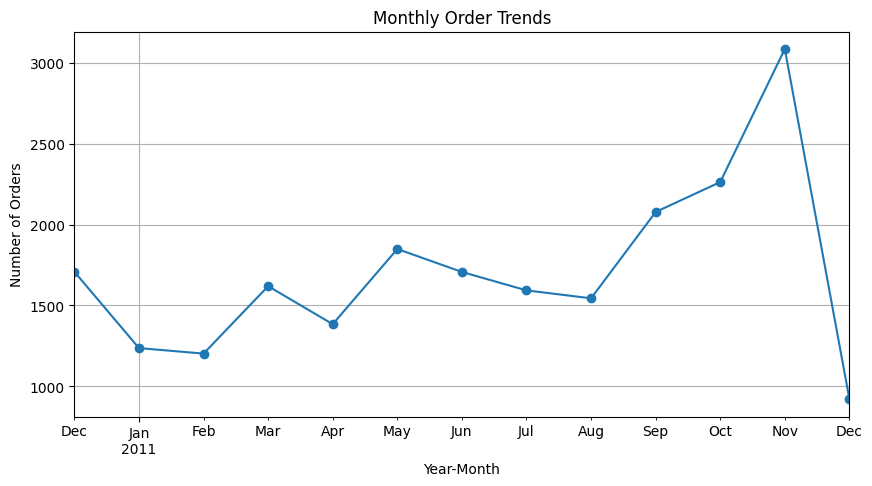

In [71]:
#3
# Extract month and year from the 'InvoiceDate'
df_project['YearMonth'] = df_project['InvoiceDate'].dt.to_period('M')

# Count orders per month
monthly_orders = df_project.groupby('YearMonth')['InvoiceNo'].nunique()
# Plotting monthly order trends
plt.figure(figsize=(10, 5))
monthly_orders.plot(kind='line', marker='o')
plt.title('Monthly Order Trends')
plt.xlabel('Year-Month')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

## 5. Geographical Analysis
   
1. Can you determine the top 5 countries with the highest number of orders?
  
2. Is there a correlation between the country of the customer and the average order
value?

In [72]:
#1
top_5_countries = df_project['Country'].value_counts().head(5)
print("\nTop 5 Countries with the Highest Number of Orders:\n")
print(top_5_countries)


Top 5 Countries with the Highest Number of Orders:

Country
United Kingdom    361878
Germany             9495
France              8491
EIRE                7485
Spain               2533
Name: count, dtype: int64


In [73]:
#2
# Calculate order value
df_project['OrderValue'] = df_project['Quantity'] * df_project['UnitPrice']

# Average order value per country
avg_order_value_per_country = df_project.groupby('Country')['OrderValue'].mean()

# Check correlation between country and average order value
correlation = avg_order_value_per_country.corr(df_project['Country'].map(avg_order_value_per_country))
print(f"\nCorrelation between Customer Country and Average Order Value: {correlation:.2f}")

C:\Users\ankur\AppData\Local\Temp\ipykernel_27156\109301678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_project['OrderValue'] = df_project['Quantity'] * df_project['UnitPrice']



Correlation between Customer Country and Average Order Value: nan


## 6. Payment Analysis
1. What are the most common payment methods used by customers?
2. Is there a relationship between the payment method and the order amount?

Ans: We do not have sufficient data present in the dataset to derive the payment methods being used by the customers.

In [83]:
#creating payment method column

df_project['PaymentMethod'] = np.random.choice(['Credit Card', 'Debit Card', 'Cash', 'Apple Pay'],size=len(df_project))

C:\Users\ankur\AppData\Local\Temp\ipykernel_27156\3335500668.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_project['PaymentMethod'] = np.random.choice(['Credit Card', 'Debit Card', 'Cash', 'Apple Pay'],size=len(df_project))


In [106]:
#1. what are the most common payment methods used by customer
print("\nThe most common payment methods used by customer are:")
print(df_project['PaymentMethod'].value_counts().head(4))


The most common payment methods used by customer are:
PaymentMethod
Debit Card     101998
Cash           101766
Apple Pay      101631
Credit Card    101434
Name: count, dtype: int64



We observed that customers orefer to pay using Credit Cards more often as it resulted in maximum order amount



C:\Users\ankur\AppData\Local\Temp\ipykernel_27156\1554207955.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_project['OrderAmount'] = df_project['Quantity']*df_project['UnitPrice']


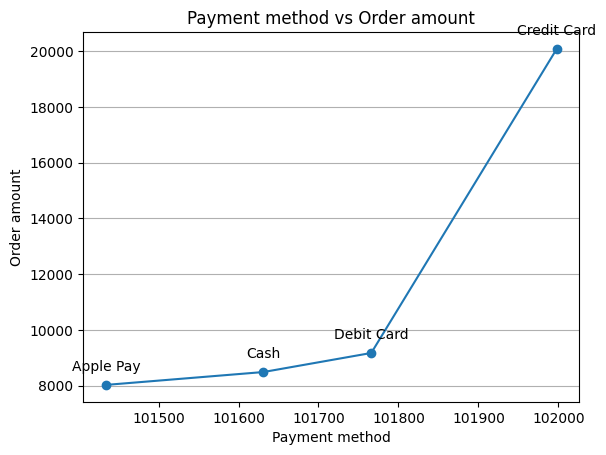

In [119]:
df_project['OrderAmount'] = df_project['Quantity']*df_project['UnitPrice']

plt.plot(df_project['PaymentMethod'].value_counts().head(4),df_project['OrderAmount'].value_counts().head(4), marker = 'o')
plt.title('Payment method vs Order amount')
plt.xlabel('Payment method')
plt.ylabel('Order amount')
plt.grid(axis='y')
i = 0
for x,y in zip(df_project['PaymentMethod'].value_counts().head(4), df_project['OrderAmount'].value_counts().head(4)):
    label = ['Credit Card', 'Debit Card', 'Cash', 'Apple Pay']
    plt.annotate(label[i], # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    i = i + 1

print("\nWe observed that customers prefer to pay using Credit Cards more often as it resulted in maximum order amount\n")

In [105]:
df_project['OrderAmount'].value_counts().head(4)

OrderAmount
15.0    20082
17.7     9174
16.5     8490
10.2     8028
Name: count, dtype: int64

## 7. Customer Behavior
   
1. How long, on average, do customers remain active (between their first and last
purchase)?
2. Are there any customer segments based on their purchase behavior?

In [75]:
#1
customer_activity = df_project.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max'])
customer_activity['activity_duration'] = (customer_activity['max'] - customer_activity['min']).dt.days

overall_average_duration = customer_activity['activity_duration'].mean()
print("\nObservation: On average, customers activity between 1st and last purchase is: "+ str(round(overall_average_duration,2))+" minutes.")


Observation: On average, customers activity between 1st and last purchase is: 133.39 minutes.


C:\Users\ankur\AppData\Local\Temp\ipykernel_27156\4145434112.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_project['InvoiceDate'] = pd.to_datetime(df_project['InvoiceDate'])
C:\Users\ankur\AppData\Local\Temp\ipykernel_27156\4145434112.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_project['DayOfWeek'] = df_project['InvoiceDate'].dt.day_name()
C:\Users\ankur\AppData\Local\Temp\ipykernel_27156\4145434112.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

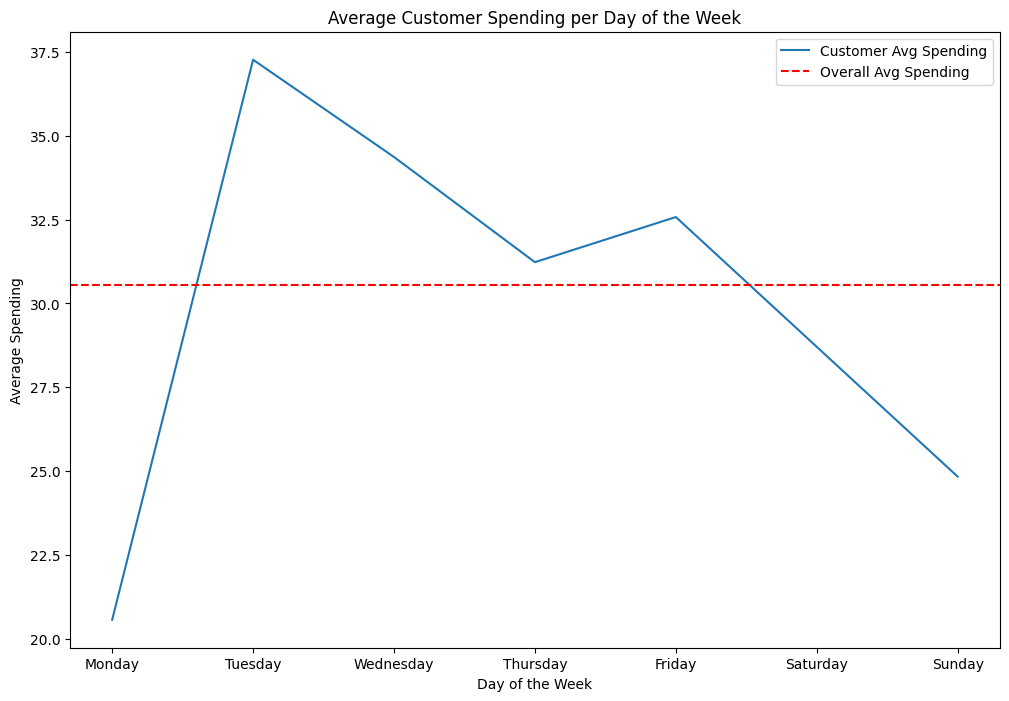


 Observation: We observed that customers tend to do purchase mostly on Tuesdays


In [76]:
#2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame with columns 'InvoiceDate', 'CustomerID', 'Quantity', 'UnitPrice'
# Ensure 'InvoiceDate' is in datetime format
df_project['InvoiceDate'] = pd.to_datetime(df_project['InvoiceDate'])

# Create a new column for the day of the week
df_project['DayOfWeek'] = df_project['InvoiceDate'].dt.day_name()

# Calculate spending for each transaction
df_project['TotalSpending'] = df_project['Quantity'] * df_project['UnitPrice']

# Group by CustomerID, DayOfWeek, and calculate the mean spending
customer_daily_spending = df_project.groupby(['CustomerID', 'DayOfWeek'])['TotalSpending'].mean().reset_index()

# Order days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
customer_daily_spending['DayOfWeek'] = pd.Categorical(customer_daily_spending['DayOfWeek'], categories=days_order, ordered=True)

# Calculate overall average spending
overall_avg_spending = customer_daily_spending['TotalSpending'].mean()

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(x='DayOfWeek', y='TotalSpending', data=customer_daily_spending, errorbar=None, label='Customer Avg Spending')
plt.axhline(overall_avg_spending, linestyle='--', color='red', label='Overall Avg Spending')

plt.title('Average Customer Spending per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Spending')
plt.legend()
plt.show()

print("\n Observation: We observed that customers tend to do purchase mostly on Tuesdays")

## 8. Returns and Refunds
   
1. What is the percentage of orders that have experienced returns or refunds?
   
2. Is there a correlation between the product category and the likelihood of returns?

In [77]:
#1
returned_orders = df_project[df_project['InvoiceNo'].apply(lambda x: x[0]=='C')]
returned_orders.head()
print("\n There are total "+str((returned_orders['Quantity']).sum())+" orders that have experienced returns or refunds. Negative sign represents returned or refunded orders")


 There are total -274808 orders that have experienced returns or refunds. Negative sign represents returned or refunded orders



We found that the itmes that were mostly returned by the customers generally belong to utility categories, 
this suggested that customer wanted to try out the product and returned them according to the convience of use



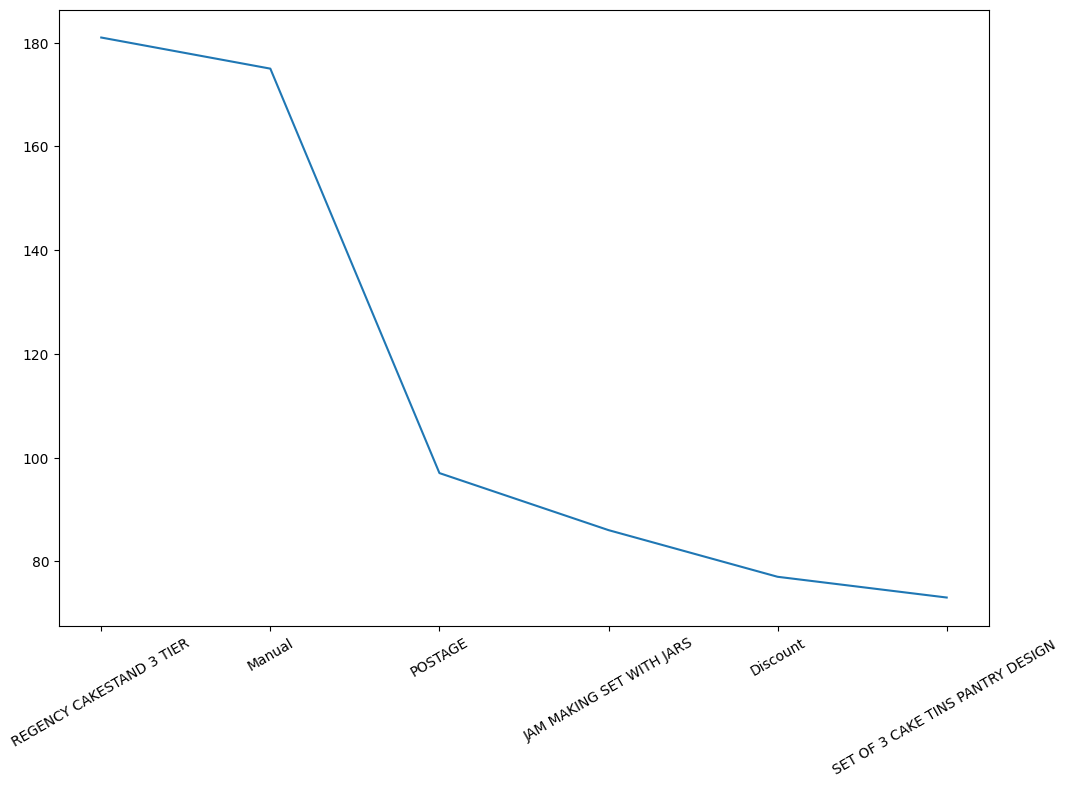

In [78]:
#2
plt.figure(figsize=(12, 8))
plt.plot(returned_orders['Description'].value_counts().head(6))
plt.xticks(rotation=30)
print("""\nWe found that the itmes that were mostly returned by the customers generally belong to utility categories, 
this suggested that customer wanted to try out the product and returned them according to the convience of use\n""")

## 9. Profitability Analysis

1. Can you calculate the total profit generated by the company during the dataset's time period?
2. What are the top 5 products with the highest profit margins?


In [128]:
#1

print("Total profit generated by the company during the dataset's time period is: $ "+ str(round(df_project['OrderAmount'].sum(),2)))
#2
print("\n The top 5 products with highest profit margins are:\n")
print(df_project['Description'].iloc[df_project['OrderAmount'].value_counts().head(5)])

Total profit generated by the company during the dataset's time period is: $ 8300065.81

 The top 5 products with highest profit margins are:

30125             CINAMMON SET OF 9 T-LIGHTS
12679                  HEART OF WICKER SMALL
11992    SET OF 20 VINTAGE CHRISTMAS NAPKINS
11485     SMALL POLKADOT CHOCOLATE GIFT BAG 
9916            PINK HEART SHAPE PHOTO FRAME
Name: Description, dtype: object


## 10. Customer Satisfaction
    
1. Is there any data available on customer feedback or ratings for products or services?
   
2. Can you analyze the sentiment or feedback trends, if available?

Ans: We do not have any recorded variable to provide a measure for the customer satisfaction in our dataset. Hence, we will be using our RFM analysis to get an overall idea about the customer satisfaction level. If customers are satisfied with the store's services then the recency and frequency would be greater.

1. High-Value Customers: Low recency, high frequency, and high monetary scores.2. Potential Loyal Customers: Recent purchases, high frequency, moderate monetary scores. 3. 
New Customers: Very recent purchases, low frequency, and low monetary score.      .4. 
Churned Customers: High recency, low frequency, and low monetary scores.

In [79]:
#1
print("\nBelow are our Customer segment analysis results:\n")
print(segment_analysis)
print("""\n Now, we can observe that we have we have greater number of Either new customers or Churned customer from our RFM analysis. 
This means that the customer satisfaction of the stores is not great and they need to work on certain things""")


Below are our Customer segment analysis results:

   Cluster   Recency  Frequency   Monetary  CustomerID
0        0 -0.509690  -0.004877  -0.011544        3294
1        1 -0.908709  65.696532  65.921437           1
2        2  1.558281  -0.046042  -0.025876        1078

 Now, we can observe that we have we have greater number of Either new customers or Churned customer from our RFM analysis. 
This means that the customer satisfaction of the stores is not great and they need to work on certain things


#2. Can you analyze the sentiment or feedback trends, if available?

Ans: We do not have any data to understand the sentiment or feedback trend in our dataset.